In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import logging

import requests
from tqdm import tqdm,tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.dvid import *
from neuclease.dvid.keyvalue import fetch_keyvalues
from neuclease.util import Timer, closest_approach
from neuclease.merge_table import normalize_recarray_inplace, generate_focused_assignment, generate_assignments
from neuclease.focused.ingest import *
from neuclease.focused.ingest import fetch_focused_decisions
from neuclease.focused.scores import calc_speculative_scores
from neuclease.focused.favorites import compute_favorites, mark_favorites, extract_favorites

In [3]:
# import imp
# import neuclease.dvid.keyvalue
# imp.reload(neuclease.dvid.keyvalue)
# from neuclease.dvid.keyvalue import fetch_keyvalues

In [4]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
#print("Cluster:")
#print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=46353180&submit_time=1536162010


In [5]:
root_logger = logging.getLogger()
root_logger.handlers = []
configure_default_logging()

In [6]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [7]:
sc

''

### UUIDS

In [8]:
# The starting agglo
initial_agglo_node = ('emdata3:8900', 'ac901')

# # The uuid used when loading the neo4j instance (for 'important bodies')
# neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# # The last supervoxel splits: One past the neo4j node
analysis_node = DvidInstanceInfo('emdata3:8900', '662e', 'segmentation')

# Current master
master_node = ('emdata3:8900', '7254')

### Analysis mapping

In [17]:
#analysis_mapping = fetch_complete_mappings(*analysis_node, 'segmentation')
analysis_mapping = fetch_mappings(*analysis_node, 'segmentation')

INFO [2018-09-05 11:45:24,831] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
INFO [2018-09-05 11:46:01,970] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:37.136331
INFO [2018-09-05 11:46:01,972] Parsing mapping...
INFO [2018-09-05 11:46:10,170] Parsing mapping took 0:00:08.195509


In [18]:
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

### Previous decisions

In [54]:
%%time
LOAD_PREVIOUS_FROM_CSV = False
_path = f'focused-decisions-{master_node[1]}-2018-08-23.csv'

if LOAD_PREVIOUS_FROM_CSV:
    df = pd.read_csv(_path)
    df.fillna(0.0, inplace=True)
    df['sv_a'] = df['sv_a'].astype(np.uint64)
    df['sv_b'] = df['sv_b'].astype(np.uint64)
    df['body_a'] = df['body_a'].astype(np.uint64)
    df['body_b'] = df['body_b'].astype(np.uint64)
    previous_focused_decisions = df
else:
    previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                         normalize_pairs='sv')

    previous_focused_decisions.to_csv(_path, index=False, header=True)

# Body info is nearly useless because they correspond to the body ID
# at the time the edge was assigned -- not the current body ID.
# Let's delete the body columns to ensure we don't accidentally try to use it for anything.
del previous_focused_decisions['body_a']
del previous_focused_decisions['body_b']

previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

assert previous_focused_decisions.eval('id_a <= id_b').all()
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

Loaded 480432 previous decisions
CPU times: user 1min 5s, sys: 8.28 s, total: 1min 13s
Wall time: 1min 35s


In [55]:
print(f"TOTAL decisions: {len(previous_focused_decisions)}")
#previous_focused_decisions['result'].value_counts()
previous_focused_decisions.eval('result == "merge" or result == "mergeLater"').sum()

TOTAL decisions: 480432


267464

In [56]:
previous_focused_decisions.columns

Index(['build version', 'initial 3D angle method', 'result', 'result history',
       'source', 'id_a', 'id_b', 'time', 'time to complete (ms)', 'time zone',
       'user', 'using hybrid meshes', 'xa', 'xb', 'ya', 'yb', 'za', 'zb'],
      dtype='object')

In [31]:
_p0 = '/nrs/flyem/bergs/complete-ffn-agglo/remaining-onehop-assignments-7254-20180823/assignment-000-adjusted.csv'
_p1 = '/nrs/flyem/bergs/complete-ffn-agglo/remaining-onehop-assignments-7254-20180823/assignment-001-adjusted.csv'

assignment0 = pd.read_csv(_p0)
assignment1 = pd.read_csv(_p1)

assignment0 = pd.concat((assignment0, assignment1))
assignment0.rename(inplace=True, columns={'supervoxel ID 1': 'id_a',
                                          'supervoxel ID 2': 'id_b',
                                          'coordinate-status': 'coordinate_status'})

In [32]:
assignment0_copy = assignment0.copy()
swap_rows = (assignment0['id_a'] > assignment0['id_b'])
assignment0.loc[swap_rows, 'id_a'] = assignment0_copy.loc[swap_rows, 'id_b']
assignment0.loc[swap_rows, 'id_b'] = assignment0_copy.loc[swap_rows, 'id_a']

assignment0.loc[swap_rows, 'xa'] = assignment0_copy.loc[swap_rows, 'xb']
assignment0.loc[swap_rows, 'ya'] = assignment0_copy.loc[swap_rows, 'yb']
assignment0.loc[swap_rows, 'za'] = assignment0_copy.loc[swap_rows, 'zb']

assignment0.loc[swap_rows, 'xb'] = assignment0_copy.loc[swap_rows, 'xa']
assignment0.loc[swap_rows, 'yb'] = assignment0_copy.loc[swap_rows, 'ya']
assignment0.loc[swap_rows, 'zb'] = assignment0_copy.loc[swap_rows, 'za']

In [33]:
ass0_prev = previous_focused_decisions.merge(assignment0, how='inner', on=['id_a', 'id_b'])

In [45]:
ass0_prev['completion_secs'] = list(map(lambda l: l[0] / 1000, ass0_prev['time to complete (ms)']))

In [34]:
ass0_prev.shape

(18784, 28)

In [46]:
ass0_prev[['completion_secs', 'result', 'coordinate_status']].head()

,completion_secs,result,coordinate_status
0,4.201,irrelevant,adjusted-at-scale-0
1,8.508,mergeLater,adjusted-at-scale-0
2,4.469,dontMerge,adjusted-at-scale-0
3,9.064,merge,adjusted-at-scale-0
4,4.917,dontMerge,adjusted-at-scale-0


In [62]:
ass0_prev.query('completion_secs < 5*60')['completion_secs'].describe()

count    18577.000000
mean        18.291978
std         32.265138
min          0.000000
25%          3.443000
50%          7.435000
75%         17.868000
max        299.279000
Name: completion_secs, dtype: float64

Time-to-complete with 'adjusted' (good) coordinates:


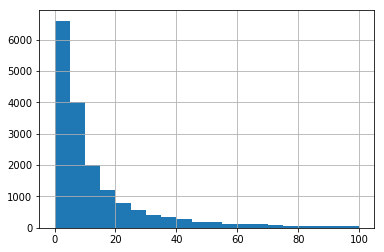

In [59]:
q = 'coordinate_status != "misplaced" and completion_secs < 100'
ass0_prev.query(q)['completion_secs'].hist(bins=20)
print("Time-to-complete with 'adjusted' (good) coordinates:")

Time-to-complete with 'misplaced' (bad) coordinates:


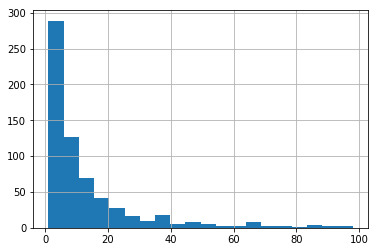

In [60]:
q = 'coordinate_status == "misplaced" and completion_secs < 100'
ass0_prev.query(q)['completion_secs'].hist(bins=20)
print("Time-to-complete with 'misplaced' (bad) coordinates:")

In [31]:
def drop_previously_reviewed(df, previous_focused_decisions_df):
    """
    Given a DataFrame of speculative focused decisions and 
    a DataFrame of previously reviewed focused decisions,
    drop all previous decisions from the speculative set,
    regardless of review results.
    """
    comparison_df = previous_focused_decisions_df[['id_a', 'id_b']].drop_duplicates()
    in_prev = df[['id_a', 'id_b']].merge(comparison_df,
                                         how='left',
                                         on=['id_a', 'id_b'],
                                         indicator='side')

    keep_rows = (in_prev['side'] == 'left_only')
    return df[keep_rows.values]

### Important bodies

In [9]:
##
## Using Analysis node state!
##

#focused_bodies_path = 'focused-7254-2tbars-2psds-10.0Mv.npy'
focused_bodies_path = 'focused-662e-2tbars-2psds-10.0Mv.npy'
focused_bodies_table = pd.DataFrame(np.load(focused_bodies_path))
focused_bodies_table.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies_table.query('PreSyn >= 2 or PostSyn >= 10 or voxel_count >= 10e6', inplace=True)

important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

Working with 703548 focused bodies


### Load/filter/score 2-hop tables

- load pre-updated tables (coords already fixed, supervoxels updated)
- normalize (`a<b`)
- filter
   - important TWO-HOP
   - non-merged
   - not yet reviewed
     - Note: this will toss out previously reviewed 'favorite' edges, meaning the next 'favorite' we pick below will be e.g. 2nd-favorite (if it survives the threshold).  Is that what we want?
- append scores

In [15]:
DROP_PREVIOUSLY_REVIEWED = False

#NODE = master_node
NODE = analysis_node

if DROP_PREVIOUSLY_REVIEWED:
    TWOHOP_OUTPUT_DIR = f'twohop-tables-including-reviewed-{NODE[1]}'
else:
    TWOHOP_OUTPUT_DIR = f'twohop-tables-excluding-reviewed-{NODE[1]}'

os.makedirs(f'{TWOHOP_OUTPUT_DIR}/32nm', exist_ok=True)
os.makedirs(f'{TWOHOP_OUTPUT_DIR}/16nm', exist_ok=True)
os.makedirs(f'{TWOHOP_OUTPUT_DIR}/8nm', exist_ok=True)

previous_sv_values = previous_focused_decisions[['id_a', 'id_b']].values

driver_cwd = os.getcwd()


def apply_mapping_and_filter_to_partition(paths):
    print("init mapping...")
    # Must create mapper here since it cannot be pickled.
    mapper = LabelMapper(master_mapping.index.values, master_mapping.values)

    # Compute once
    print("init sv pairs...")
    previous_sv_pairs = set(map(tuple, previous_sv_values))

    def apply_mapping_and_filter(npy_path):
        """
        Load the table from the given npy file,
        apply the body mapping, and remove rows with matching bodies.
        Also remove rows that correspond to decisions that have already been made.
        
        The resulting filtered table is stored in 'twohop-tables-*-reviewed-*/*nm/',
        (See TWOHOP_OUTPUT_DIR, above.)
        """
        print("loading table...")
        table = np.load(npy_path)
        df = pd.DataFrame(table)

        print("mapping bodies...")
        # A bug above caused the type to be int64. Fix that now.
        df['id_a'] = df['id_a'].astype(np.uint64, copy=False)
        df['id_b'] = df['id_b'].astype(np.uint64, copy=False)
        
        df['body_a'] = mapper.apply(df['id_a'].values, allow_unmapped=True)
        df['body_b'] = mapper.apply(df['id_b'].values, allow_unmapped=True)

        important_bodies, TWOHOP_OUTPUT_DIR # Referenced to ensure capture in this closure

        print("filtering...")
        # Drop internal edges,
        # Filter for important bodies (on at least one end -- capture 1-hop and 2-hop)
        q = '(body_a != body_b) and ((body_a in @important_bodies) or (body_b in @important_bodies))'
        df.query(q, inplace=True)

        print("normalizing...")
        table = df.to_records(index=False)
        normalize_recarray_inplace(table, 'id_a', 'id_b',
                                  ['id_a', 'body_a', 'xa', 'ya', 'za', 'caa', 'cba', 'da'],
                                  ['id_b', 'body_b', 'xb', 'yb', 'zb', 'cbb', 'cab', 'db'])
        df = pd.DataFrame(table)
        if DROP_PREVIOUSLY_REVIEWED:
            df = drop_previously_reviewed(df, previous_focused_decisions)
        
        print("scores...")
        df['score'] = calc_speculative_scores(df[['caa', 'cab', 'cba', 'cbb']].to_records(index=False))
        
        print("writing...")
        res = df['resolution'].iloc[0]
        fname = os.path.split(npy_path)[-1]
        output_path = f'{driver_cwd}/{TWOHOP_OUTPUT_DIR}/{res}nm/{fname}'
        np.save(output_path, df.to_records(index=False))

        return len(df)
    
    return list(map(apply_mapping_and_filter, paths))

In [17]:
# Test one first
#%time apply_mapping_and_filter_to_partition(['updated-tables/32nm/data-00000-of-00100.npy'])

In [18]:
filtered_totals = {}

for res in [32, 16, 8]:
    with Timer(f"Processing {res}nm..."):
        paths = map(os.path.abspath, glob.glob(f'updated-tables/{res}nm/data-*.npy'))
        filtered_totals[res] = sc.parallelize(paths).mapPartitions(apply_mapping_and_filter_to_partition).sum()
    
print(f"DONE. Total filtered edges: {sum(filtered_totals.values())}")

INFO [2018-08-24 11:14:21,898] Processing 32nm......
INFO [2018-08-24 11:15:44,347] Processing 32nm... took 0:01:22.447598
INFO [2018-08-24 11:15:44,350] Processing 16nm......
INFO [2018-08-24 11:17:18,383] Processing 16nm... took 0:01:34.032903
INFO [2018-08-24 11:17:18,388] Processing 8nm......
INFO [2018-08-24 11:19:16,355] Processing 8nm... took 0:01:57.966335
DONE. Total filtered edges: 907113216


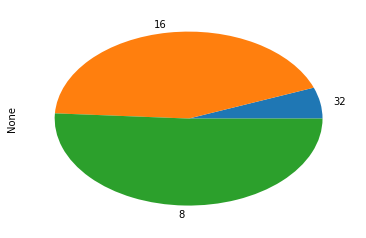

In [19]:
pd.Series(filtered_totals).plot(kind='pie')

### Select 1-hop edges

In [22]:
driver_cwd = os.getcwd()

#NODE = master_node
NODE = analysis_node

if DROP_PREVIOUSLY_REVIEWED:
    ONEHOP_OUTPUT_DIR = f'{driver_cwd}/onehop-tables-excluding-reviewed-{NODE[1]}'
else:
    ONEHOP_OUTPUT_DIR = f'{driver_cwd}/onehop-tables-including-reviewed-{NODE[1]}'
    
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/32nm', exist_ok=True)
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/16nm', exist_ok=True)
os.makedirs(f'{ONEHOP_OUTPUT_DIR}/8nm', exist_ok=True)


def select_and_write_onehop(twohop_path):
    important_bodies # ref for pickle

    print("reading...")
    df = pd.DataFrame(np.load(twohop_path))
    res = df['resolution'].iloc[0]
    
    print("filtering...")
    q = 'body_a in @important_bodies and body_b in @important_bodies'
    df.query(q, inplace=True)
    
    print("writing...")
    fname = os.path.split(twohop_path)[-1]
    output_path = f'{ONEHOP_OUTPUT_DIR}/{res}nm/{fname}'
    np.save(output_path, df.to_records(index=False))
    return len(df)

all_twohop_chunk_paths = map(os.path.abspath, glob.glob(f'{TWOHOP_OUTPUT_DIR}/*nm/*.npy'))
total_onehop_edges = sc.parallelize(all_twohop_chunk_paths).map(select_and_write_onehop).sum()
print(f"Selected {total_onehop_edges} one-hop edges")

Selected 234436514 one-hop edges


### Load into combined table

In [24]:
all_onehop_chunk_paths = glob.glob(f'{ONEHOP_OUTPUT_DIR}/*nm/*.npy')
all_onehop_chunks = list(map(np.load, tqdm_notebook(all_onehop_chunk_paths)))
combined_onehop_table = np.concatenate(all_onehop_chunks)
del all_onehop_chunks
print(f"Combined table is {combined_onehop_table.nbytes / 1e9:.1f} GB")

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Combined table is 20.9 GB


In [25]:
%time combined_onehop_df = pd.DataFrame(combined_onehop_table)

CPU times: user 51.7 s, sys: 13.7 s, total: 1min 5s
Wall time: 46.2 s


In [26]:
combined_onehop_df.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,cba,cbb,iou,da,db,resolution,body_a,body_b,score
0,1012359606,1135833306,16448,23743,15961,16401,23783,15924,0.982629,0.000000,0.001461,0.992530,0.000019,0.002408,0.000507,8,5813039957,1135828787,0.001461
1,1016749434,1016753364,10412,30574,14398,10406,30626,14399,0.986544,0.000000,0.000000,0.947968,0.000000,0.001237,0.002138,8,1016749259,1016758041,0.000000
2,1049662264,1049662419,27573,32595,14852,27513,32615,14878,0.991906,0.002317,0.000069,0.918828,0.000000,0.002363,0.003926,8,613175370,5813049530,0.002317
3,1075054375,1167852620,12425,24956,16373,12436,24992,16339,0.777855,0.000000,0.000000,0.970840,0.000000,0.009229,0.000394,8,890191637,823058891,0.000000
4,1097365311,1097706148,23432,14451,15693,23444,14463,15684,0.994048,0.000359,0.000000,0.905296,0.000000,0.000107,0.000662,8,5813040784,973566036,0.000359


In [27]:
### Discard unneeded columns
%time combined_onehop_df = combined_onehop_df[['id_a', 'id_b', 'body_a', 'body_b', 'score', 'xa', 'ya', 'za', 'xb', 'yb', 'zb']].copy()

CPU times: user 25.3 s, sys: 17.6 s, total: 42.9 s
Wall time: 5.44 s


In [28]:
combined_onehop_df.memory_usage().sum() / 1e9

14.06619092

### Pre-threshold by score

Thresholded table has 2.3M rows (0.2 GB)


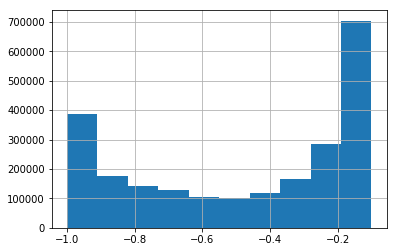

In [30]:
thresholded_df = combined_onehop_df[combined_onehop_df['score'] >= 0.1].copy()

_rows = len(thresholded_df)
_nbytes = thresholded_df.memory_usage().sum()
print(f"Thresholded table has {_rows/1e6:.1f}M rows ({_nbytes/1e9:.1f} GB)")

# Michal's scores use "higher is better",
# but compute_favorites() assumes "lower is better"
thresholded_df['score'] *= -1
thresholded_df['score'].hist()

### Choose favorites

In [31]:
%%time
body_favorites = compute_favorites(thresholded_df)
print(f"Found {len(body_favorites)} favorites")

Found 376703 favorites
CPU times: user 1min 40s, sys: 9.51 s, total: 1min 50s
Wall time: 1min 19s


In [32]:
%%time
favorite_flags_df = mark_favorites(thresholded_df, body_favorites)
favorite_onehop_df = extract_favorites(thresholded_df, favorite_flags_df, only_mutual=False)

CPU times: user 7.97 s, sys: 2.68 s, total: 10.6 s
Wall time: 831 ms


### Exclude previously reviewed (if they weren't pre-excluded above)

In [34]:
edges_were_dropped_above = DROP_PREVIOUSLY_REVIEWED

if not edges_were_dropped_above:
    print("dropping previous decisions...")
    previous_sv_values = previous_focused_decisions[['id_a', 'id_b']].values
    previous_sv_pairs = set(map(tuple, previous_sv_values))

    # Drop edges that have already been considered.
    sv_pairs = list(map(tuple, favorite_onehop_df[['id_a', 'id_b']].values))
    favorite_onehop_df['sv_pair'] = sv_pairs
    favorite_onehop_df = favorite_onehop_df[~(favorite_onehop_df['sv_pair'].isin(previous_sv_pairs))]
    del favorite_onehop_df['sv_pair']

    print(f"{len(favorite_onehop_df)} favorites remain after dropping previously-reviewed")

dropping previous decisions...
169983 favorites remain after dropping previously-reviewed


In [35]:
favorite_onehop_df = favorite_onehop_df[['id_a','id_b','body_a','body_b','xa','ya','za','xb','yb','zb','score']]
favorite_onehop_df.to_csv('remaining-onehop-assignments-7254-20180824.csv', index=False)

In [36]:
favorite_onehop_df.shape

(169983, 11)

### Generate assignments

In [37]:
generate_assignments(favorite_onehop_df, 10_000, 'remaining-onehop-assignments-7254-20180824')

100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


In [38]:
# sample assignment
np.random.seed(0)
_choices = np.random.choice(favorite_onehop_df.index, size=(100,), replace=False)
_ = generate_focused_assignment(favorite_onehop_df.loc[_choices],
                                'remaining-onehop-assignments-7254-20180824-SAMPLE-ASSIGNMENT.json')

## Just use Michal's iteration 1

In [14]:
# Load all iteration 1 edges
it1_path = ('/nrs/flyem/bergs/final-agglo/speculative-iterations/'
         + 'final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy')

it1_table = np.load(it1_path)
normalize_recarray_inplace(it1_table, 'id_a', 'id_b', ['id_a', 'xa', 'ya', 'za'], ['id_b', 'xb', 'yb', 'zb'])
it1_df = pd.DataFrame(it1_table)

In [17]:
# Apply body mapping from current master node
it1_df['body_a'] = master_mapper.apply(it1_df['id_a'].values, True)
it1_df['body_b'] = master_mapper.apply(it1_df['id_b'].values, True)

In [23]:
# Filter for 1-hop edges only
it1_df.query('body_a in @important_bodies and body_b in @important_bodies', inplace=True)

In [25]:
# Drop internal edges for assigning
it1_df.query('body_a != body_b', inplace=True)

In [32]:
assert it1_df.eval('id_a <= id_b').all()
assert previous_focused_decisions.eval('id_a <= id_b').all()
%time it1_df = drop_previously_reviewed(it1_df, previous_focused_decisions)

CPU times: user 3.77 s, sys: 1.41 s, total: 5.18 s
Wall time: 513 ms


In [37]:
print(f"Assigning {len(it1_df)} filtered it1 edges")

Assigning 18388 filtered it1 edges


### Generate assignments

In [39]:
generate_assignments(it1_df, 5000, 'remaining-it1-assignments-7254-20180830')

100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


In [35]:
# sample assignment
np.random.seed(0)
_choices = np.random.choice(it1_df.index, size=(100,), replace=False)
_ = generate_focused_assignment(it1_df.loc[_choices],
                                'remaining-it1-assignments-7254-20180830-SAMPLE-ASSIGNMENT.json')

### De-duplicate body pairs?

In [36]:
it1_df.duplicated(['body_a', 'body_b']).sum()

914

In [65]:
# it1_records = it1_df.to_records(index=False)
# normalize_recarray_inplace(it1_records, 'body_a', 'body_b',
#                            ['body_a', 'id_a', 'xa', 'ya', 'za'],
#                            ['body_b', 'id_b', 'xb', 'yb', 'zb'])
# it1_deduplicated_df = pd.DataFrame(it1_records).drop_duplicates(['body_a', 'body_b'])
# len(it1_deduplicated_df)

32952

In [213]:
#it1_deduplicated_df['score'].hist()

In [ ]:
#it1_deduplicated_df.query('score > 13.1')['score'].hist()

In [ ]:
#it1_deduplicated_df['score'][it1_deduplicated_df['score'] > 13.1].shape

In [ ]:
#len(it1_thresholded_df)/len(it1_deduplicated_df)

In [188]:
#claire_assignments = glob.glob('remaining-*-7254-2018082*-SAMPLE-ASSIGNMENT.json')
claire_assignments = ['remaining-onehop-assignments-7254-20180824-SAMPLE-ASSIGNMENT.json']

claire_edges = []
for path in claire_assignments:
    with open(path, 'r') as f:
        assignment = json.load(f)
        for task in assignment['task list']:
            pair = (task['supervoxel ID 1'], task['supervoxel ID 2'])
            claire_edges.append(pair)

claire_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged', normalize_pairs='sv',
                                           subset_pairs=claire_edges, show_progress=True)

100%|██████████| 50/50 [00:00<00:00, 295.91it/s]


In [189]:
claire_decisions.shape

(50, 19)

In [190]:
#it1_df.query('id_a == 955469006 or id_b == 955469006')

In [191]:
#previous_focused_decisions.query('id_a == 955469006')

In [161]:
#claire_decisions.iloc[-200:][['time', 'user', 'sv_a', 'sv_b', 'body_a', 'body_b', 'result']].sort_values('time')

In [114]:
psd_bodies = focused_bodies_table.query('PostSyn >= 10 and PreSyn < 2')

In [115]:
empty_bodies = focused_bodies_table.query('PostSyn < 10 and PreSyn < 2')

In [192]:
def get_type(body):
    if body in empty_bodies.index:
        return 'empty'
    elif body in psd_bodies.index:
        return 'psd'
    else:
        return 'tbar'

claire_decisions['type_a'] = list(map(get_type, claire_decisions['body_a']))
claire_decisions['type_b'] = list(map(get_type, claire_decisions['body_b']))

In [193]:
claire_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})
drop_previously_reviewed_inplace(claire_decisions, previous_focused_decisions)

0

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 25]

types = np.sort(claire_decisions[['type_a', 'type_b']].values, axis=1)
type_results = pd.DataFrame(types, columns=['t1', 't2'])
type_results['result'] = claire_decisions['result'].values
type_results

fig, axs = plt.subplots(5,1)

for i, (key, group) in enumerate(type_results.groupby(['t1', 't2'])):
    title = f"{key[0]}/{key[1]}"
    group['result'].value_counts().plot(kind='bar', ax=axs[i], title=title, ylim=(0,15))

plt.subplots_adjust(top=2, bottom=1, wspace=None, hspace=None)

In [198]:
df = claire_decisions[['time', 'user', 'id_a', 'id_a', 'body_a', 'body_b', 'result', 'type_a', 'type_b']].sort_values('time')

In [217]:
_k = fetch_keys(*master_node, 'focused_complete_02')

In [225]:
#_k

In [221]:
fetch_key(*master_node, 'focused_complete_02', '1001794547_1001799164')

b'{"status":"Not examined","supervoxel point 1":[15787,11257,14348],"comment":"iteration-evaluation, iteration-1","supervoxel ID 1":1001794547,"coordinate-status":"adjusted","assigned":22771,"supervoxel point 2":[15786,11258,14347],"supervoxel ID 2":1001799164,"focused ID":"1001794547_1001799164","task type":"body merge"}\n'

### Previously assigned It1

In [25]:
%%time
assigned_it1_decisions = fetch_focused_decisions('emdata3:8900', '7254', 'focused_complete_02',
                                                 normalize_pairs='sv')

CPU times: user 4.36 s, sys: 694 ms, total: 5.05 s
Wall time: 7.08 s


In [26]:
assert assigned_it1_decisions.eval('sv_a <= sv_b').all()

In [27]:
assigned_it1_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

In [28]:
#assigned_it1_decisions['status'].value_counts().plot(kind='pie')

In [29]:
assigned_it1_decisions.shape

(50923, 14)

In [30]:
it1_df.shape

(135035, 11)

In [31]:
# Append score from it1 table
assigned_it1_decisions = assigned_it1_decisions.merge(it1_df[['id_a', 'id_b', 'score']],
                                                      on=['id_a', 'id_b'], how='left')

In [32]:
assigned_it1_decisions['body_a'] = master_mapper.apply(assigned_it1_decisions['id_a'].values, True)
assigned_it1_decisions['body_b'] = master_mapper.apply(assigned_it1_decisions['id_b'].values, True)

In [33]:
# Append results
assigned_it1_decisions = assigned_it1_decisions.merge(previous_focused_decisions[['id_a', 'id_b', 'result']],
                                                      on=['id_a', 'id_b'], how='left')

In [34]:
assigned_it1_decisions[['id_a', 'id_b', 'body_a', 'body_b', 'score', 'result']].head()

,id_a,id_b,body_a,body_b,score,result
0,1001794547,1001799164,939725093,939725093,13.023951,merge
1,1001794547,1001799164,939725093,939725093,13.023951,merge
2,1002473020,1033848591,878333234,1001794614,13.038699,dontMerge
3,1002843708,1260055739,1002507131,1002507131,13.063377,merge
4,1002843708,1353159845,1002507131,1002507131,13.011014,merge


In [35]:
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = [5, 5]

plt.subplots_adjust(top=1, bottom=0, wspace=None, hspace=None)
#plt.clf()
#plt.cla()
#plt.close()

<Figure size 360x360 with 0 Axes>

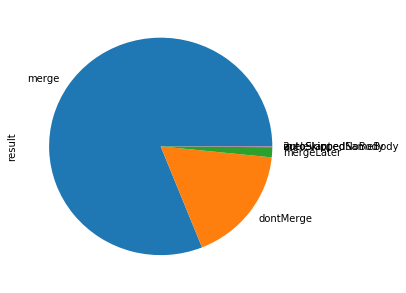

In [36]:
assigned_it1_decisions['result'].value_counts().plot(kind='pie')

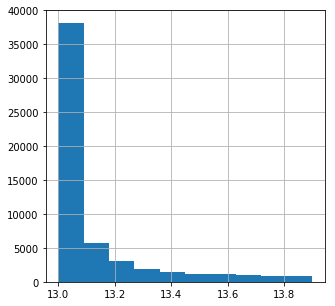

In [37]:
assigned_it1_decisions['score'].hist()

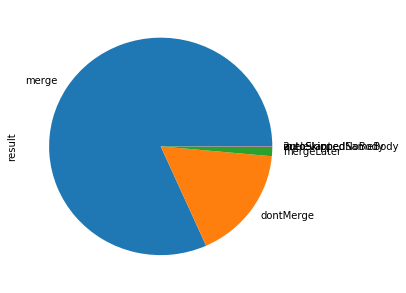

In [38]:
assigned_it1_decisions.query('score > 13.0 and score <= 13.1')['result'].value_counts().plot(kind='pie')

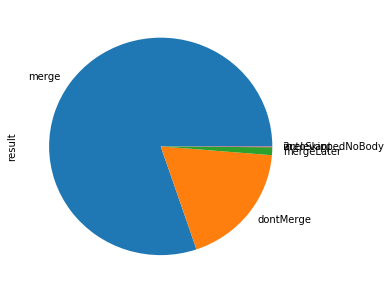

In [39]:
assigned_it1_decisions.query('score > 13.1 and score <= 13.2')['result'].value_counts().plot(kind='pie')

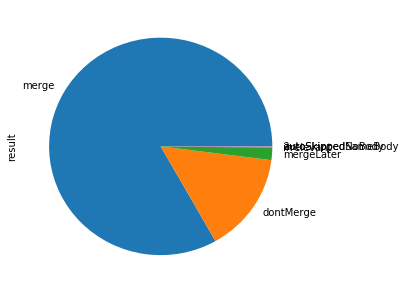

In [40]:
assigned_it1_decisions.query('score > 13.2 and score <= 13.3')['result'].value_counts().plot(kind='pie')

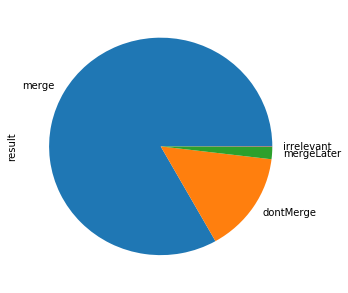

In [41]:
assigned_it1_decisions.query('score > 13.3 and score <= 13.4')['result'].value_counts().plot(kind='pie')

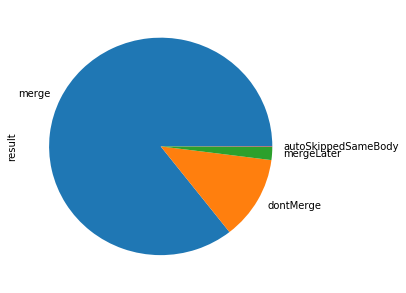

In [42]:
assigned_it1_decisions.query('score > 13.4 and score <= 13.5')['result'].value_counts().plot(kind='pie')

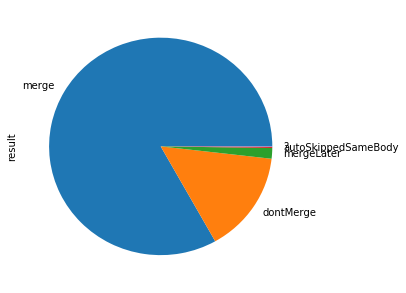

In [43]:
assigned_it1_decisions.query('score > 13.5 and score <= 13.6')['result'].value_counts().plot(kind='pie')

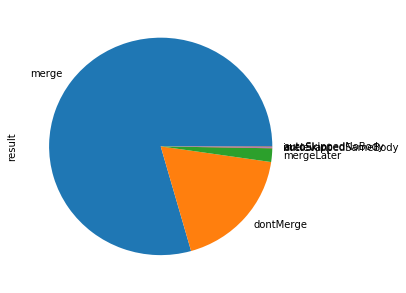

In [44]:
assigned_it1_decisions.query('score > 13.6 and score <= 13.7')['result'].value_counts().plot(kind='pie')

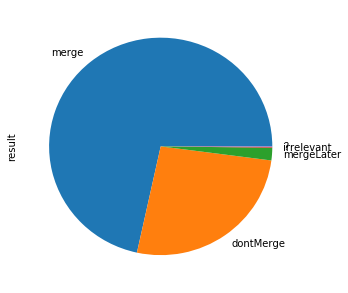

In [45]:
assigned_it1_decisions.query('score > 13.7 and score <= 13.8')['result'].value_counts().plot(kind='pie')

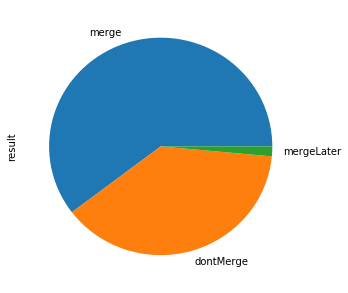

In [46]:
assigned_it1_decisions.query('score > 13.8 and score <= 13.9')['result'].value_counts().plot(kind='pie')

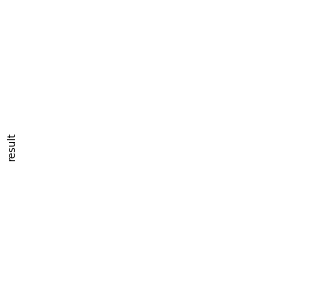

In [47]:
assigned_it1_decisions.query('score > 13.9 and score <= 14')['result'].value_counts().plot(kind='pie')

#### New it1 edges

In [48]:
unreviewed_it1_df = drop_previously_reviewed(it1_df, previous_focused_decisions)

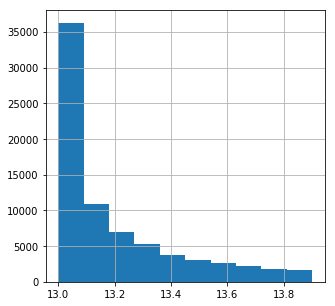

In [49]:
unreviewed_it1_df['score'].hist()


Previously assigned scores:


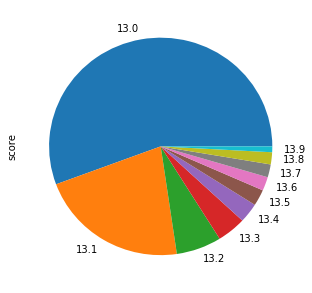

In [74]:
assigned_score_counts = assigned_it1_decisions['score'].round(1).value_counts()
assigned_score_counts.index = list(map(lambda score: f'{score:.1f}', assigned_score_counts.index))
assigned_score_counts.plot(kind='pie')
print("")
print("Previously assigned scores:")


New batch scores:


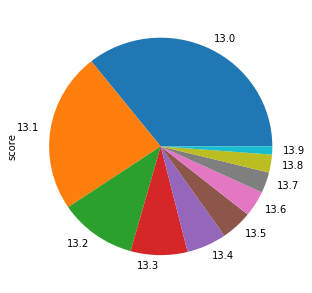

In [58]:
score_counts = unreviewed_it1_df['score'].round(1).value_counts()
score_counts.index = list(map(lambda score: f'{score:.1f}', score_counts.index))
score_counts.plot(kind='pie')
print("")
print("New batch scores:")

In [64]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure

In [237]:
assigned_merge_counts = (assigned_it1_decisions.query('result == "merge" or result == "mergeLater"')['score']
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())
assigned_merge_counts.index.name = 'score'
assigned_merge_counts.name = 'count'
assigned_merge_counts = pd.DataFrame(assigned_merge_counts).reset_index()
assigned_merge_counts.sort_values('score', inplace=True)
assigned_merge_counts.query('score != "nan"', inplace=True)


assigned_dontmerge_counts = (assigned_it1_decisions.query('result == "dontMerge"')['score']
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())
assigned_dontmerge_counts.index.name = 'score'
assigned_dontmerge_counts.name = 'count'
assigned_dontmerge_counts = pd.DataFrame(assigned_dontmerge_counts).reset_index()
assigned_dontmerge_counts.sort_values('score', inplace=True)
assigned_dontmerge_counts.query('score != "nan"', inplace=True)

merge_max = assigned_merge_counts['count'].max()
dontmerge_max = assigned_dontmerge_counts['count'].max()

p = figure( y_range=assigned_merge_counts['score'][::-1],
            plot_height=300,
            x_range=(-dontmerge_max*1.1, merge_max*1.1),
            title="(Don't) Merge Counts by Score" )

p.hbar(assigned_merge_counts['score'],
       0.9,
       assigned_merge_counts['count'],
       color='navy')

p.hbar(assigned_dontmerge_counts['score'],
       0.9,
       0,
       -assigned_dontmerge_counts['count'],
       color='crimson')

show(p)

merge_count_table = assigned_merge_counts.merge(assigned_dontmerge_counts,
                                                how='outer', on='score', suffixes=['_merge', '_dontMerge'])
merge_count_table['ratio'] = merge_count_table['count_merge'] / ( merge_count_table['count_merge'] + merge_count_table['count_dontMerge'] )
merge_count_table[['score', 'ratio']].set_index('score')

,ratio
score,
13.0,0.834992
13.1,0.816562
13.2,0.830147
13.3,0.835847
13.4,0.874456
13.5,0.873028
13.6,0.834960
13.7,0.772427
13.8,0.688822


In [372]:
focused_bodies_table.query('PreSyn == 2')

(95278, 4)

In [373]:
len(focused_bodies_table)

589778

In [238]:
focused_bodies_table.head()

,voxel_count,PostSyn,PreSyn
body,,,
1497973422,11823856010,8308.0,65.0
5813024096,10992947053,7393.0,111.0
262840563,10356857879,716.0,615.0
263199096,9677149202,51.0,36.0
262504004,8350396028,215.0,326.0


In [267]:
#filtered_tbar_bodies_table = focused_bodies_table.query('(PreSyn + PostSyn) < 100')

In [312]:
it1_decisions_a = assigned_it1_decisions.merge(focused_bodies_table,
                                               how='inner', left_on='body_a', right_index=True)

it1_decisions_b = assigned_it1_decisions.merge(focused_bodies_table,
                                               how='inner', left_on='body_b', right_index=True)

it1_decisions = pd.concat((it1_decisions_a, it1_decisions_b))
it1_decisions['TotalSyn'] = it1_decisions.eval('PreSyn + PostSyn')

In [271]:
small_it1_decisions_a['TotalSyn'] = small_it1_decisions_a.eval('PreSyn + PostSyn')

In [378]:
!uname -n

h09u03.int.janelia.org


In [342]:
def show_merge_ratios(decisions_table, binned_column, bin_size, num_bins, show_ratio=False):
    bin_range = (0, bin_size*num_bins)

    merged_decisions = decisions_table.query('result == "merge" or result == "mergeLater"')
    merged_syncounts = merged_decisions[binned_column]
    merged_bincounts, merged_bins = np.histogram(merged_syncounts.values, num_bins, range=bin_range)

    notmerged_decisions = decisions_table.query('result == "dontMerge"')
    notmerged_syncounts = notmerged_decisions[binned_column]
    notmerged_bincounts, notmerged_bins = np.histogram(notmerged_syncounts.values, num_bins, range=bin_range)

    merged_data = merged_bincounts
    not_merged_data = notmerged_bincounts
    
    if show_ratio:
        merged_ratio = merged_bincounts / (merged_bincounts + notmerged_bincounts)
        notmerged_ratio = notmerged_bincounts / (merged_bincounts + notmerged_bincounts)

        merged_ratio = np.nan_to_num(merged_ratio)
        notmerged_ratio = np.nan_to_num(notmerged_ratio)
        
        merged_data = merged_ratio
        not_merged_data = notmerged_ratio

    label = {True: "Ratio", False: "Counts"}[show_ratio]
    p = figure( y_range=bin_range,
                plot_height=400,
                x_range=(-1.05*not_merged_data.max(), 1.05*merged_data.max()),
                title=f"(Don't) Merge {label} by {binned_column}",
                x_axis_label=f"Decision {label} (Don't Merge/Merge)",
                y_axis_label=f"{binned_column} (bin = {bin_size})")

    p.hbar((merged_bins[:-1] + merged_bins[1:])/2,
           bin_size*0.9,
           merged_data,
           0,
           color='navy')

    p.hbar((merged_bins[:-1] + merged_bins[1:])/2,
           bin_size*0.9,
           0,
           -not_merged_data,
           color='crimson')

    show(p)

In [345]:
show_ratio = True
show_merge_ratios(it1_decisions, 'PreSyn', bin_size=1, num_bins=50, show_ratio=show_ratio)
show_merge_ratios(it1_decisions, 'PostSyn', bin_size=1, num_bins=50, show_ratio=show_ratio)
show_merge_ratios(it1_decisions, 'TotalSyn', bin_size=1, num_bins=50, show_ratio=show_ratio)

/groups/flyem/proj/cluster/miniforge/envs/flyem/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/groups/flyem/proj/cluster/miniforge/envs/flyem/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [361]:
#it1_decisions.head()

In [377]:
# Consider only 2-tbar bodies
table = it1_decisions.copy()
table['psd_ratio'] = table.eval('PostSyn / PreSyn')

#show_merge_ratios(it1_decisions.query('PreSyn == 2'), 'PreSyn', bin_size=1, num_bins=50)
#show_merge_ratios(it1_decisions.query('PreSyn == 2'), 'PostSyn', bin_size=1, num_bins=20, show_ratio=False)
show_merge_ratios(it1_decisions.query('PreSyn < 2'), 'PostSyn', bin_size=1, num_bins=20, show_ratio=False)
#show_merge_ratios(it1_decisions.query('PreSyn < 2'), 'PostSyn', bin_size=1000000, num_bins=20, show_ratio=False)
#show_merge_ratios(it1_decisions.query('PreSyn == 2'), 'voxel_count', bin_size=1000000, num_bins=20, show_ratio=True)
#show_merge_ratios(table.query('PreSyn >= 1 and PreSyn <= 10'), 'psd_ratio', bin_size=1, num_bins=10)
#show_merge_ratios(it1_decisions.query('PreSyn == 2'), 'TotalSyn', bin_size=1, num_bins=50)

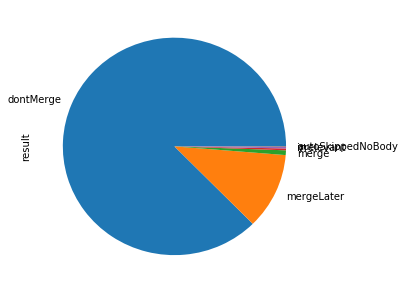

In [367]:
it1_decisions.query('PreSyn == 2')['result'].value_counts().plot(kind='pie')

In [368]:
len(it1_decisions.query('PreSyn == 2')) / len(it1_decisions)

0.036166022189295655

In [369]:
len(it1_decisions)

110684

In [371]:
it1_decisions.query('PreSyn == 2').shape

(4003, 22)

In [331]:
small_it1_decisions_a = (small_it1_decisions.query('result == "merge" or result == "mergeLater"')
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())

TypeError: ('unsupported format string passed to Series.__format__', 'occurred at index assigned')

In [257]:
small_assigned_merge_counts = (small_it1_decisions.query('result == "merge" or result == "mergeLater"')['score']
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())
small_assigned_merge_counts.index.name = 'score'
small_assigned_merge_counts.name = 'count'
small_assigned_merge_counts = pd.DataFrame(small_assigned_merge_counts).reset_index()
small_assigned_merge_counts.sort_values('score', inplace=True)
small_assigned_merge_counts.query('score != "nan"', inplace=True)

small_assigned_dontmerge_counts = (small_it1_decisions.query('result == "dontMerge"')['score']
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())
small_assigned_dontmerge_counts.index.name = 'score'
small_assigned_dontmerge_counts.name = 'count'
small_assigned_dontmerge_counts = pd.DataFrame(small_assigned_dontmerge_counts).reset_index()
small_assigned_dontmerge_counts.sort_values('score', inplace=True)
small_assigned_dontmerge_counts.query('score != "nan"', inplace=True)

In [258]:
merge_max = small_assigned_merge_counts['count'].max()
dontmerge_max = small_assigned_dontmerge_counts['count'].max()

p = figure( y_range=small_assigned_merge_counts['score'][::-1],
            plot_height=300,
            x_range=(-dontmerge_max*1.1, merge_max*1.1),
            title="2-tbar body (Don't) Merge Counts by Score" )

p.hbar(small_assigned_merge_counts['score'],
       0.9,
       small_assigned_merge_counts['count'],
       color='navy')

p.hbar(small_assigned_dontmerge_counts['score'],
       0.9,
       0,
       -small_assigned_dontmerge_counts['count'],
       color='crimson')

show(p)

merge_count_table = small_assigned_merge_counts.merge(small_assigned_dontmerge_counts,
                                                      how='outer', on='score', suffixes=['_merge', '_dontMerge'])
merge_count_table['ratio'] = merge_count_table['count_merge'] / ( merge_count_table['count_merge'] + merge_count_table['count_dontMerge'] )
merge_count_table[['score', 'ratio']].set_index('score')

,ratio
score,
13.0,0.210412
13.1,0.250000
13.2,0.287500
13.3,0.222222
13.4,0.240000
13.5,0.308824
13.6,0.256098
13.7,0.115789
13.8,0.119048


In [256]:
unreviewed_counts = (unreviewed_it1_df['score']
                          .round(1).apply(lambda v: f'{v:.1f}').value_counts())
unreviewed_counts.index.name = 'score'
unreviewed_counts.name = 'count'
unreviewed_counts = pd.DataFrame(unreviewed_counts).reset_index()

unreviewed_max = unreviewed_counts['count'].max()

p = figure( y_range=unreviewed_counts['score'],
            plot_height=300,
            x_range=(0, unreviewed_max*1.1),
            title="Unreviewed Counts by Score" )

p.hbar(unreviewed_counts['score'][::-1],
       0.9,
       0,
       unreviewed_counts['count'],
       color='green')

show(p)

PSD counts for assigned 2-tbar bodies:


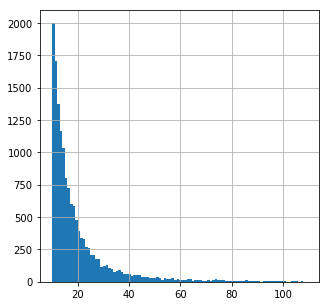

In [184]:
focused_bodies_table.query('PreSyn == 2 and PostSyn >= 10 and PostSyn < 110')['PostSyn'].hist(bins=100)
print("PSD counts for assigned 2-tbar bodies:")

PSD counts for newly assigned 0/1-tbar bodies:


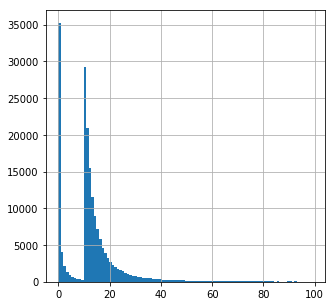

In [187]:
focused_bodies_table.query('PreSyn < 2 and PostSyn < 100')['PostSyn'].hist(bins=100)
print("PSD counts for newly assigned 0/1-tbar bodies:")


T-bar counts


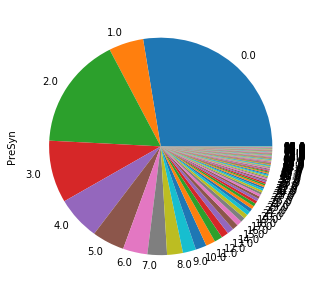

In [178]:
focused_bodies_table.query('PreSyn >= 0 and PreSyn < 100')['PreSyn'].value_counts().sort_index().plot(kind='pie')
print("\nT-bar counts")

## Remove double-2-tbar bodies

In [10]:
recent_assigned = pd.read_csv('remaining-onehop-assignments-7254-20180824.csv')

In [19]:
recent_assigned['body_a'] = analysis_mapper(recent_assigned['id_a'].values, True)
recent_assigned['body_b'] = analysis_mapper(recent_assigned['id_b'].values, True)

NameError: name 'analysis_mapper' is not defined

In [13]:
focused_bodies_table.head()

,voxel_count,PostSyn,PreSyn
body,,,
1497973422,11818299675,8308,65
5813024096,10985904465,7393,109
263199096,9674671304,51,34
262840563,9591276440,386,468
5813021092,9522426145,2933,1160


In [ ]:
recent_assigned = recent_assigned.merge(focused_bodies_table, left_)